In [ ]:
CellOracle to aPTxPTS12 cells

Step 0
SEURAT to anndata get RNA:  annadata2ri_pip enviromental 

[Step 1](https://morris-lab.github.io/CellOracle.documentation/notebooks/01_ATAC-seq_data_processing/option1_scATAC-seq_data_analysis_with_cicero/01_atacdata_analysis_with_cicero_and_monocle3.html) - Get the SeuratObject ATAC data to cds ATAC data using cicero with per_step1_Seurat_to_cds_fortmat.Rmd 



[Step 2](https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/01_ATAC-seq_data_processing/option1_scATAC-seq_data_analysis_with_cicero/02_preprocess_peak_data.ipynb) - TSS annotation

In [1]:
outputdata="./"
res="per_aPTxPTS12_"
inputdata="./"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm

from celloracle import motif_analysis as ma
import celloracle as co
co.__version__

'0.12.0'

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300


In [4]:
# Load scATAC-seq peak list.
peaks = pd.read_csv(f"{inputdata}all_peaks.csv", index_col=0)
peaks = peaks.x.values
peaks

array(['chr1_9921_10519', 'chr1_99560_99792', 'chr1_102545_103036', ...,
       'chrY_56836410_56837085', 'chrY_56855620_56855818',
       'chrY_56870782_56870980'], dtype=object)

In [5]:
# Load Cicero coaccessibility scores.
cicero_connections = pd.read_csv(f"{inputdata}cicero_connections.csv", index_col=0)
cicero_connections.head()

Peak1                    Peak2  coaccess
1  chr10_100009209_100010434  chr10_99754510_99755035  0.000000
2  chr10_100009209_100010434  chr10_99767717_99768026 -0.002121
3  chr10_100009209_100010434  chr10_99770181_99770860 -0.009139
4  chr10_100009209_100010434  chr10_99775530_99776183 -0.005862
5  chr10_100009209_100010434  chr10_99777972_99778219 -0.000690

In [6]:
##!! Please make sure to specify the correct reference genome here
tss_annotated = ma.get_tss_info(peak_str_list=peaks, ref_genome="hg38") 
# Check results
tss_annotated.tail()

que bed peaks: 137993
tss peaks in que: 21470


chr      start        end gene_short_name strand
21465  chr14   71931844   71932650            RGS6      +
21466   chr1   10430155   10431066      CENPS-CORT      +
21467   chr5  149550894  149552018         CSNK1A1      -
21468  chr20   10673218   10675009            JAG1      -
21469   chr9  122228539  122228936            LHX6      -

In [7]:
integrated = ma.integrate_tss_peak_with_cicero(tss_peak=tss_annotated, 
                                               cicero_connections=cicero_connections)
print(integrated.shape)
integrated.head()

(387929, 3)


peak_id gene_short_name  coaccess
0  chr10_100009209_100010434         BLOC1S2  0.005440
1  chr10_100009209_100010434           DNMBP  1.000000
2  chr10_100009209_100010434       DNMBP-AS1  0.000624
3  chr10_100009209_100010434        OLMALINC  0.140614
4  chr10_100009209_100010434             SCD  0.013748

In [8]:
peak = integrated[integrated.coaccess >= 0.8]
peak = peak[["peak_id", "gene_short_name"]].reset_index(drop=True)
peak.to_csv(f"{outputdata}{res}processed_peak_file.csv")
print(peak.shape)
peak.head()

(19300, 2)


peak_id gene_short_name
0  chr10_100009209_100010434           DNMBP
1  chr10_100081352_100081817            CPN1
2  chr10_100185297_100187090          ERLIN1
3  chr10_100228669_100229800            CHUK
4  chr10_100267102_100268162         CWF19L1

Step 3 - Transcription factor binding motif scan

[Link 1] (https://morris-lab.github.io/CellOracle.documentation/tutorials/motifscan.html)

[Link 2] (https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/02_motif_scan/02_atac_peaks_to_TFinfo_with_celloracle_20200801.ipynb)



In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns

import os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm

import celloracle as co
from celloracle import motif_analysis as ma
from celloracle.utility import save_as_pickled_object
co.__version__

'0.12.0'

In [10]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = (15,7)
plt.rcParams["savefig.dpi"] = 600

In [11]:
ref_genome = "hg38"

genome_installation = ma.is_genome_installed(ref_genome=ref_genome)
print(ref_genome, "installation: ", genome_installation)

if not genome_installation:
    import genomepy
    genomepy.install_genome(name=ref_genome, provider="UCSC")
else:
    print(ref_genome, "is installed.")

hg38 installation:  True
hg38 is installed.


In [12]:
# # Load annotated peak data.
peaks = pd.read_csv(f"{outputdata}{res}processed_peak_file.csv", index_col=0)
peaks.head()

peak_id gene_short_name
0  chr10_100009209_100010434           DNMBP
1  chr10_100081352_100081817            CPN1
2  chr10_100185297_100187090          ERLIN1
3  chr10_100228669_100229800            CHUK
4  chr10_100267102_100268162         CWF19L1

In [13]:
def decompose_chrstr(peak_str):
    """
    Args:
        peak_str (str): peak_str. e.g. 'chr1_3094484_3095479'
        
    Returns:
        tuple: chromosome name, start position, end position
    """
    
    *chr_, start, end = peak_str.split("_")
    chr_ = "_".join(chr_)
    return chr_, start, end

from genomepy import Genome

def check_peak_format(peaks_df, ref_genome):
    """
    Check peak format. 
     (1) Check chromosome name. 
     (2) Check peak size (length) and remove sort DNA sequences (<5bp)
    
    """
    
    df = peaks_df.copy()
    
    n_peaks_before = df.shape[0]
    
    # Decompose peaks and make df
    decomposed = [decompose_chrstr(peak_str) for peak_str in df["peak_id"]]
    df_decomposed = pd.DataFrame(np.array(decomposed), index=peaks_df.index)
    df_decomposed.columns = ["chr", "start", "end"]
    df_decomposed["start"] = df_decomposed["start"].astype(int)
    df_decomposed["end"] = df_decomposed["end"].astype(int)
    
    # Load genome data
    genome_data = Genome(ref_genome)
    all_chr_list = list(genome_data.keys())
    
    
    # DNA length check
    lengths = np.abs(df_decomposed["end"] - df_decomposed["start"])
    
    
    # Filter peaks with invalid chromosome name
    n_threshold = 5
    df = df[(lengths >= n_threshold) & df_decomposed.chr.isin(all_chr_list)]
    
    # DNA length check
    lengths = np.abs(df_decomposed["end"] - df_decomposed["start"])
    
    # Data counting
    n_invalid_length = len(lengths[lengths < n_threshold])
    n_peaks_invalid_chr = n_peaks_before - df_decomposed.chr.isin(all_chr_list).sum()
    n_peaks_after = df.shape[0]
    
    
    #
    print("Peaks before filtering: ", n_peaks_before)
    print("Peaks with invalid chr_name: ", n_peaks_invalid_chr)
    print("Peaks with invalid length: ", n_invalid_length)
    print("Peaks after filtering: ", n_peaks_after)
    
    return df

peaks = check_peak_format(peaks, ref_genome)


Peaks before filtering:  19300
Peaks with invalid chr_name:  0
Peaks with invalid length:  0
Peaks after filtering:  19300


In [14]:
#3. Instantiate TFinfo object and search for TF binding motifs
# Instantiate TFinfo object
tfi = ma.TFinfo(peak_data_frame=peaks, 
                ref_genome=ref_genome) 
len(tfi.all_target_gene)

16893

In [15]:
%%time
# Scan motifs. !!CAUTION!! This step may take several hours if you have many peaks!
tfi.scan(fpr=0.02, 
         motifs=None,  # If you enter None, default motifs will be loaded.
         verbose=True)
# Save tfinfo object
tfi.to_hdf5(file_path=f"{outputdata}{res}tfi_scan.celloracle.tfinfo")

No motif data entered. Loading default motifs for your species ...
 Default motif for vertebrate: gimme.vertebrate.v5.0. 
 For more information, please see https://gimmemotifs.readthedocs.io/en/master/overview.html 

Initiating scanner... 

Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



scanning:   0%|          | 0/17117 [00:00<?, ? sequences/s]

CPU times: user 16min 6s, sys: 40.7 s, total: 16min 47s
Wall time: 16min 47s


In [16]:
# Check motif scan results
tfi.scanned_df.head()

seqname           motif_id factors_direct  \
0  chr10_100009209_100010434  GM.5.0.Mixed.0001                  
1  chr10_100009209_100010434  GM.5.0.Mixed.0001                  
2  chr10_100009209_100010434  GM.5.0.Mixed.0001                  
3  chr10_100009209_100010434  GM.5.0.Mixed.0001                  
4  chr10_100009209_100010434  GM.5.0.Mixed.0001                  

  factors_indirect     score  pos  strand  
0        SRF, EGR1  8.578792  587      -1  
1        SRF, EGR1  8.319869  846      -1  
2        SRF, EGR1  7.919846  954      -1  
3        SRF, EGR1  7.680395  955      -1  
4        SRF, EGR1  7.575280  583      -1

In [17]:
# Reset filtering 
tfi.reset_filtering()

# Do filtering
tfi.filter_motifs_by_score(threshold=10)

# Format post-filtering results.
tfi.make_TFinfo_dataframe_and_dictionary(verbose=True)

Filtering finished: 13007593 -> 2396532
1. Converting scanned results into one-hot encoded dataframe.


  0%|          | 0/17117 [00:00<?, ?it/s]

2. Converting results into dictionaries.


  0%|          | 0/16893 [00:00<?, ?it/s]

  0%|          | 0/1094 [00:00<?, ?it/s]

In [18]:
# 5. Get final base GRN
# 5.1. Get results as a dataframe
df = tfi.to_dataframe()
df.head()

peak_id gene_short_name  9430076C15RIK  AC002126.6  \
0  chr10_100009209_100010434           DNMBP              0           0   
1  chr10_100081352_100081817            CPN1              0           0   
2  chr10_100185297_100187090          ERLIN1              0           1   
3  chr10_100228669_100229800            CHUK              0           0   
4  chr10_100267102_100268162         CWF19L1              0           0   

   AC012531.1  AC226150.2  AFP  AHR  AHRR  AIRE  ...  ZNF784  ZNF8  ZNF816  \
0           0           0    0    0     0     0  ...       0     0       0   
1           0           0    0    0     0     0  ...       0     0       0   
2           0           0    0    1     1     0  ...       0     0       0   
3           0           0    0    0     0     0  ...       0     0       0   
4           0           0    0    0     0     0  ...       0     0       0   

   ZNF85  ZSCAN10  ZSCAN16  ZSCAN22  ZSCAN26  ZSCAN31  ZSCAN4  
0      0        0        0        0        0        0       0  
1      0        0        0        0        0        0       0  
2      0        0        0        0        0        0       0  
3      0        0        0        0        0        0       1  
4      0        0        0        1        0        0       0  

[5 rows x 1096 columns]

In [19]:
# Save result as a dataframe
df = tfi.to_dataframe()
df.to_parquet(f"{outputdata}{res}base_GRN_dataframe.parquet")

[Step 4](https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/04_Network_analysis/Network_analysis_with_Paul_etal_2015_data.ipynb)
- Network_analysis


In [20]:
# 0. Import
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
%matplotlib inline


import os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm


import celloracle as co
co.__version__

'0.12.0'

In [21]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [22]:
save_folder = "figures_per"
os.makedirs(save_folder, exist_ok=True)

In [23]:
# Load data.
# Attention: Replace the data path below when using your data.
adata = sc.read_h5ad(f"{inputdata}scMEGA_cor40_multiome_subset_aPTxPTS12.h5ad")
adata.obs.columns = adata.obs.columns.str.replace(r"[.]", "_")
adata.obs.columns = adata.obs.columns.str.replace(r"[-]", "_")

In [24]:
adata.obs

library  nCount_RNA  nFeature_RNA  percent_er  \
KC98_AAACAGCCAAAGCTCC-1     KC98      3362.0          1952    0.356612   
KC98_AAACAGCCACGAATCC-1     KC98      1328.0           908    0.371195   
KC98_AAACCGGCAAACTAAG-1     KC98     14110.0          3864    0.310844   
KC98_AAACCGGCATGTTGCA-1     KC98     11166.0          3536    0.348525   
KC98_AAACGGATCATTGACA-1     KC98      4477.0          2355    1.358980   
...                          ...         ...           ...         ...   
KC114_TTTCCTGAGGCTGTCA-1   KC114      3447.0          1910    1.456311   
KC114_TTTCGTCCAATAAGCA-1   KC114      2702.0          1776    1.729849   
KC114_TTTCGTCCAATGCGCT-1   KC114      3558.0          1892    0.561640   
KC114_TTTGTCTAGCAAGGGT-1   KC114       682.0           525    1.739130   
KC114_TTTGTTGGTTCGCGCT-1   KC114      6874.0          2825    0.623008   

                          percent_mt  degen_score  aEpi_score  aStr_score  \
KC98_AAACAGCCAAAGCTCC-1     0.089153     0.160623    0.935775    0.172747   
KC98_AAACAGCCACGAATCC-1     1.410542     0.162018    0.467199    0.204153   
KC98_AAACCGGCAAACTAAG-1     0.317909     0.134484    0.888572    0.445804   
KC98_AAACCGGCATGTTGCA-1     0.214477     0.175002    0.689673    0.476598   
KC98_AAACGGATCATTGACA-1     6.397658     0.804648    1.475112    0.295937   
...                              ...          ...         ...         ...   
KC114_TTTCCTGAGGCTGTCA-1    1.570531     0.605422    0.851918    0.412479   
KC114_TTTCGTCCAATAAGCA-1    0.552079     0.588576    0.944182    0.294303   
KC114_TTTCGTCCAATGCGCT-1    0.084246     0.175664    0.957873    0.241051   
KC114_TTTGTCTAGCAAGGGT-1    1.159420     0.197805    0.299111    0.131014   
KC114_TTTGTTGGTTCGCGCT-1    0.405680     0.205859    0.998173    0.467758   

                          cyc_score  matrisome_score  ...  tf_target_166  \
KC98_AAACAGCCAAAGCTCC-1    0.229437         0.171853  ...       0.116386   
KC98_AAACAGCCACGAATCC-1    0.093200         0.080135  ...      -0.054836   
KC98_AAACCGGCAAACTAAG-1    0.150954         0.116369  ...      -0.013335   
KC98_AAACCGGCATGTTGCA-1    0.110011         0.103030  ...      -0.013207   
KC98_AAACGGATCATTGACA-1    0.034018         0.151819  ...       0.351952   
...                             ...              ...  ...            ...   
KC114_TTTCCTGAGGCTGTCA-1   0.165884         0.175778  ...       0.116129   
KC114_TTTCGTCCAATAAGCA-1   0.120573         0.077753  ...       0.136768   
KC114_TTTCGTCCAATGCGCT-1   0.093567         0.158497  ...       0.080322   
KC114_TTTGTCTAGCAAGGGT-1   0.039874         0.102852  ...       0.033733   
KC114_TTTGTTGGTTCGCGCT-1   0.130256         0.053619  ...       0.068354   

                          tf_target_167  tf_target_168  tf_target_169  \
KC98_AAACAGCCAAAGCTCC-1        0.022756       0.144549       0.131765   
KC98_AAACAGCCACGAATCC-1       -0.023323      -0.024478      -0.024211   
KC98_AAACCGGCAAACTAAG-1        0.281782       0.044827       0.046212   
KC98_AAACCGGCATGTTGCA-1        0.148030       0.039102       0.030631   
KC98_AAACGGATCATTGACA-1        0.188131       0.346351       0.341815   
...                                 ...            ...            ...   
KC114_TTTCCTGAGGCTGTCA-1      -0.001711       0.133037       0.117192   
KC114_TTTCGTCCAATAAGCA-1      -0.023610       0.143562       0.137147   
KC114_TTTCGTCCAATGCGCT-1       0.023281       0.098858       0.092548   
KC114_TTTGTCTAGCAAGGGT-1      -0.045069       0.017890       0.025939   
KC114_TTTGTTGGTTCGCGCT-1       0.033235       0.115087       0.122444   

                          tf_target_170 tf_target_171 tf_target_172  \
KC98_AAACAGCCAAAGCTCC-1        0.059537      0.088132      0.156221   
KC98_AAACAGCCACGAATCC-1       -0.086476     -0.066802     -0.023309   
KC98_AAACCGGCAAACTAAG-1        0.323209     -0.101857     -0.033889   
KC98_AAACCGGCATGTTGCA-1        0.173980     -0.123980     -0.052319   
KC98_AAACGGATCATTGACA-1        0.166705      0.283735      0.36814

[Step 5](https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/03_scRNA-seq_data_preprocessing/scanpy_preprocessing_with_Paul_etal_2015_data.ipynb)

In [26]:
adata.obsm['X_scmegadiff'] = adata.obsm['X_diffmap']
del adata.obsm['X_diffmap']

In [27]:
#Neighbors base on PCA
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
# Calculate neihbors again based on diffusionmap 
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_scmegadiff')
#adata.obs_keys

In [28]:
#7 Cell clustering
sc.tl.louvain(adata, resolution=0.8)

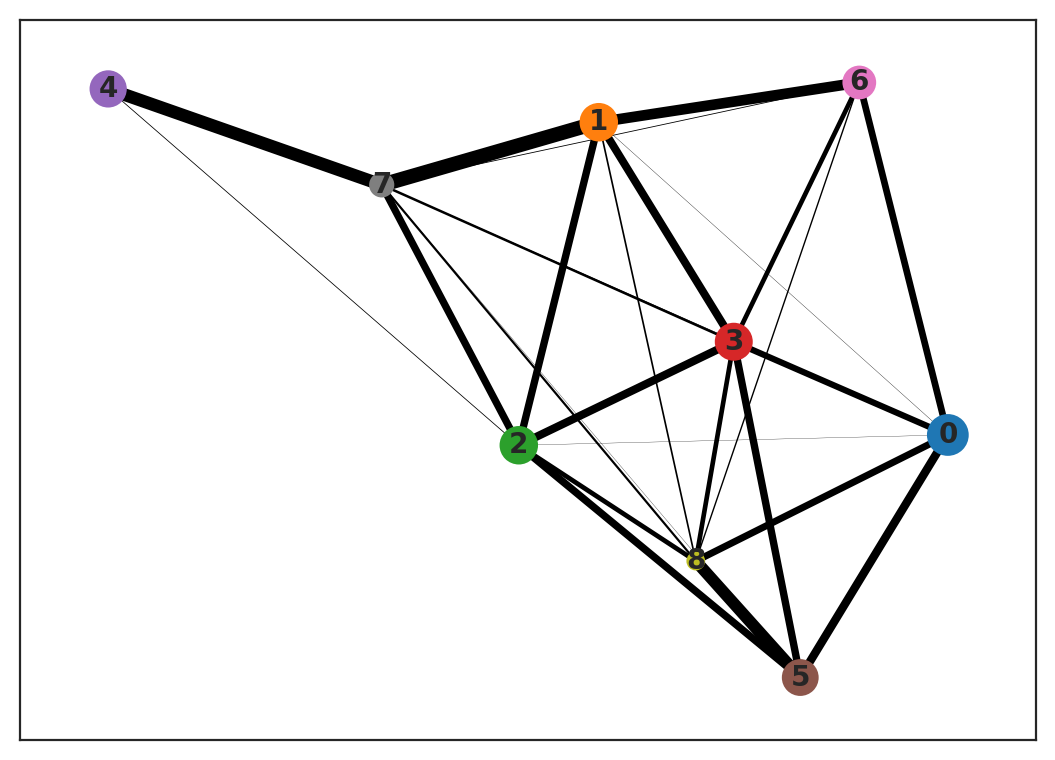

In [29]:
# PAGA graph construction
sc.tl.paga(adata, groups='louvain',)
plt.rcParams["figure.figsize"] = [6, 4.5]
sc.pl.paga(adata)

In [30]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123) #Need install pip install fa2 is not in the docker from cellorale

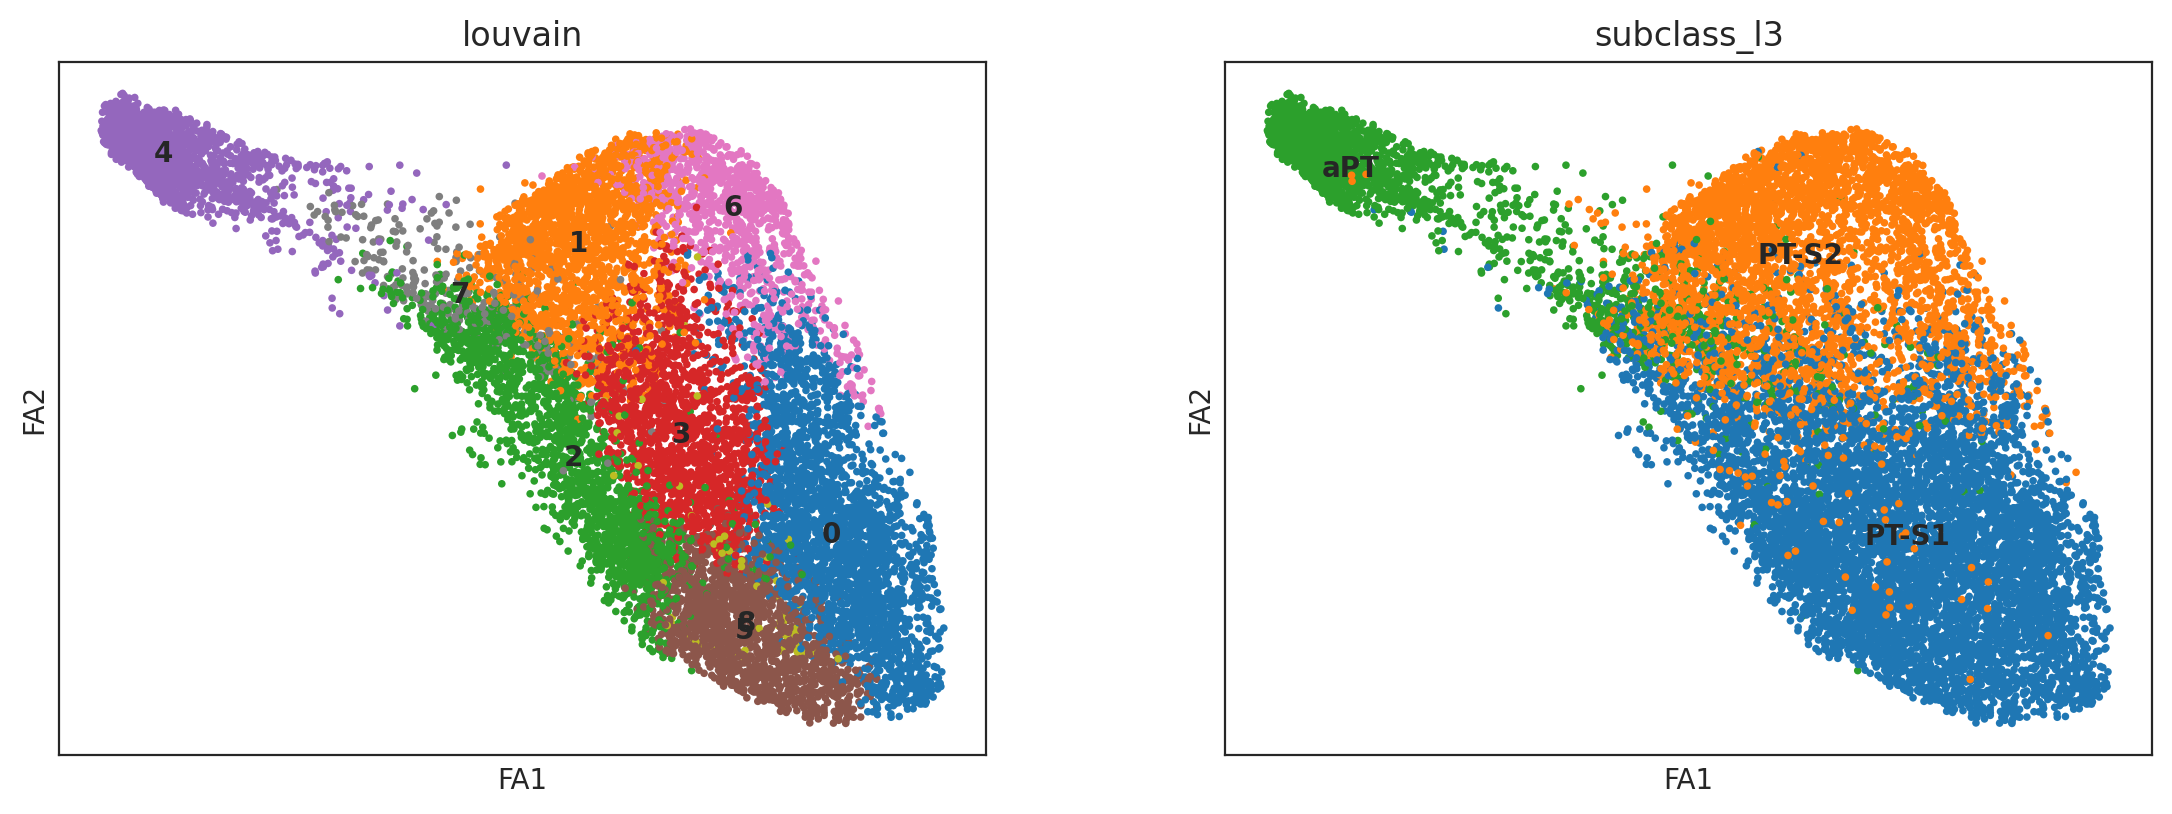

In [31]:
sc.pl.draw_graph(adata, color=['louvain', 'subclass_l3'],size=30,
                 legend_loc='on data')

In [32]:
# Check current cluster name
cluster_list = adata.obs.louvain.unique()
cluster_list

['1', '3', '0', '4', '5', '2', '6', '7', '8']
Categories (9, object): ['1', '3', '0', '4', ..., '2', '6', '7', '8']

In [33]:
#####
# 0 - PT-S1-A
# 1 - PT-S2-A 
# 2 - PT-S1-B 
# 3 - PT-S1-C
# 4 - aPT-A
# 5 - PT-S1-D
# 6 - PT-S2-B
# 7 - aPT-B
# 8 - PT-S1-E

# Make cluster anottation dictionary
annotation = {"PT-S1":[0,2,3,5,8],
              "PT-S2": [1,6],
              "aPT":[4,7]}

# Change dictionary format
annotation_rev = {}
for i in cluster_list:
    for k in annotation:
        if int(i) in annotation[k]:
            annotation_rev[i] = k
            
# Check dictionary
annotation_rev


{'1': 'PT-S2',
 '3': 'PT-S1',
 '0': 'PT-S1',
 '4': 'aPT',
 '5': 'PT-S1',
 '2': 'PT-S1',
 '6': 'PT-S2',
 '7': 'aPT',
 '8': 'PT-S1'}

In [34]:
adata.obs["cell_type"] = [annotation_rev[i] for i in adata.obs.louvain]

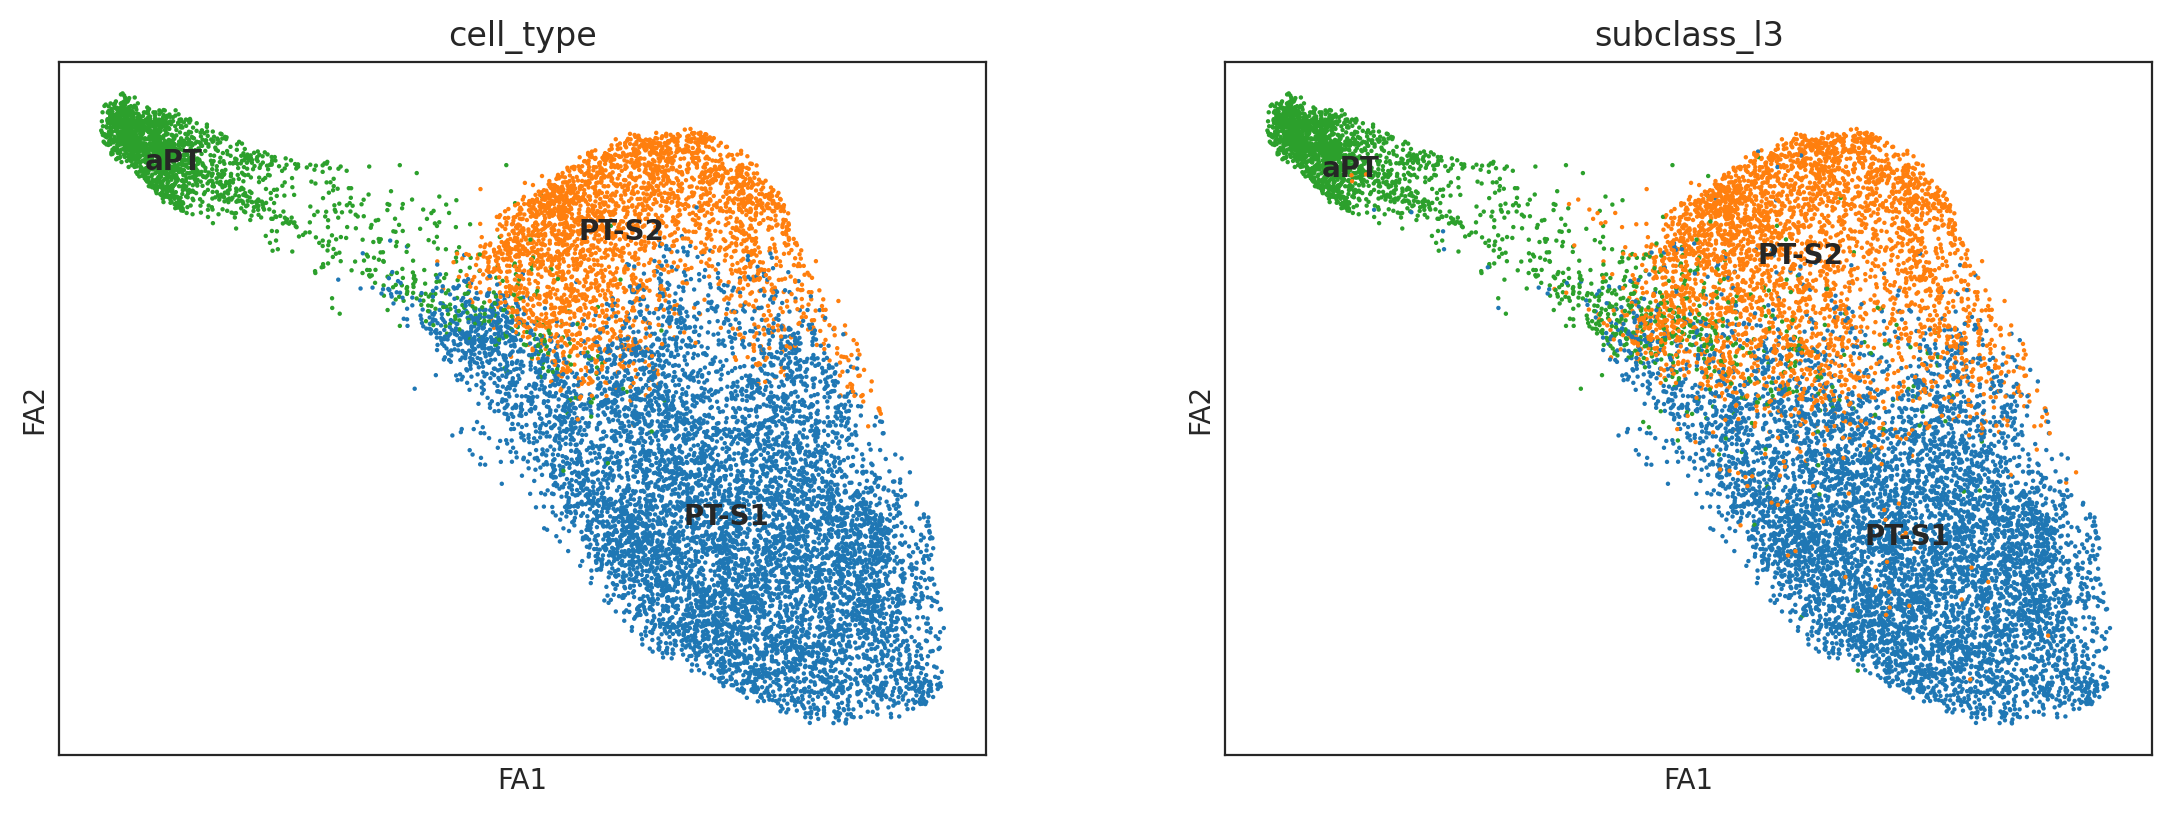

In [35]:
sc.pl.draw_graph(adata, color=['cell_type', 'subclass_l3'],
                 legend_loc='on data')

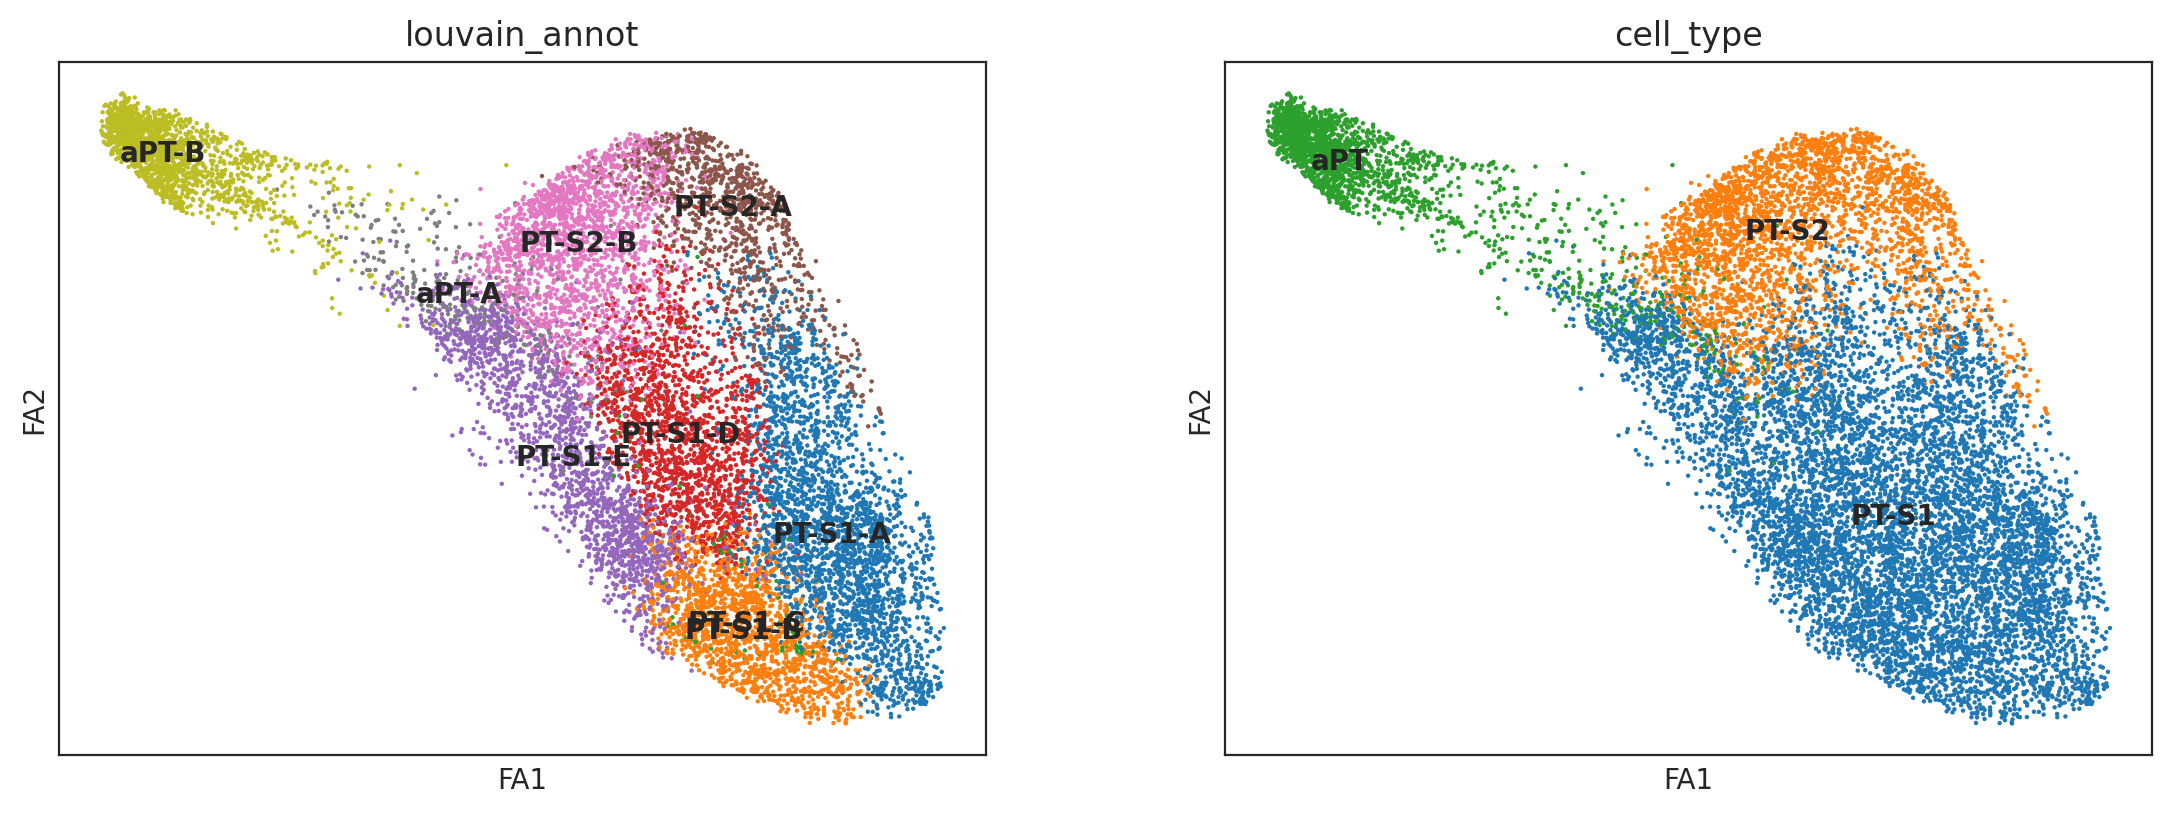

In [36]:
annotation_2 = {
"0":  "PT-S1-A",
"1":  "PT-S2-B",
"2":  "PT-S1-E",
"3":  "PT-S1-D",
"4":  "aPT-B",
"5":  "PT-S1-B",
"6":  "PT-S2-A",
"7":  "aPT-A",
"8":  "PT-S1-C"}

adata.obs["louvain_annot"] = [annotation_2[i] for i in adata.obs.louvain]

# Check result
sc.pl.draw_graph(adata, color=['louvain_annot',"cell_type"],
                 legend_loc='on data')



In [37]:
adata.write_h5ad(f"{outputdata}{res}scMEGA_cor40_step_0.h5ad")

In [38]:
#Load base-GRN data
base_GRN= pd.read_parquet(f"{outputdata}{res}base_GRN_dataframe.parquet")

In [39]:
#2. Make Oracle object
# Instantiate Oracle object
oracle = co.Oracle()

In [40]:
raw_counts = pd.read_csv(f"{inputdata}raw_counts_RNA_scMEGA_aPTxPT.csv",index_col=0)
raw_counts=np.transpose(raw_counts)

In [41]:
adata.layers["raw_counts"] = raw_counts

In [43]:
# In this notebook, we use the unscaled RNA count for the input of Oracle object.
adata.X = adata.layers["raw_counts"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="louvain_annot",
                                   embedding_name='X_draw_graph_fa')

36554 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


In [44]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [45]:
# Save oracle object.
oracle.to_hdf5(f"{outputdata}{res}scMEGA_cor40_step1.celloracle.oracle")

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
co.__version__

import os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


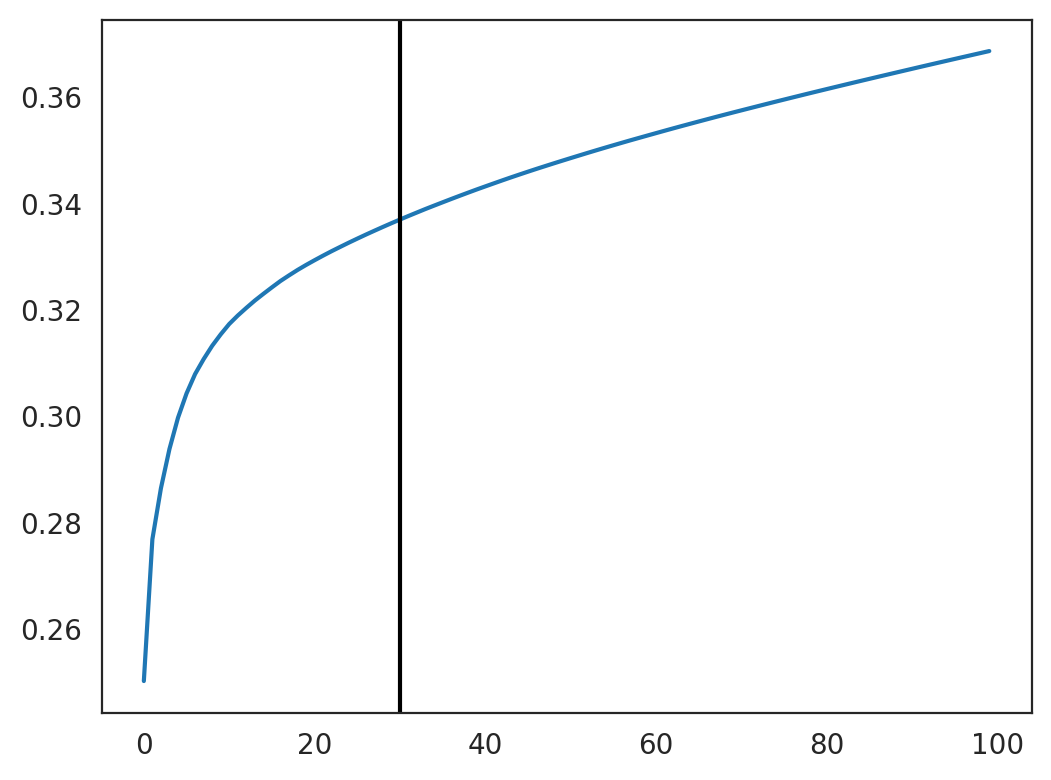

30


In [47]:
#3. KNN imputation

# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
# Make sure n_comps is between 30 and 50
# It likes to go to 0 for noise controls
n_comps = max(min(n_comps, 50), 30)
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)  

In [48]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :11917


In [49]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :297


In [50]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In [1]:
#4. Save and Load.
# Save oracle object.
oracle.to_hdf5(f"{outputdata}{res}scMEGA_cor40_step2.celloracle.oracle")

In [52]:
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.12.0
    n_cells: 11917
    n_genes: 36554
    cluster_name: louvain_annot
    dimensional_reduction_name: X_draw_graph_fa
    n_target_genes_in_TFdict: 16893 genes
    n_regulatory_in_TFdict: 1094 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 865 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 15388 genes
    k_for_knn_imputation: 297
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

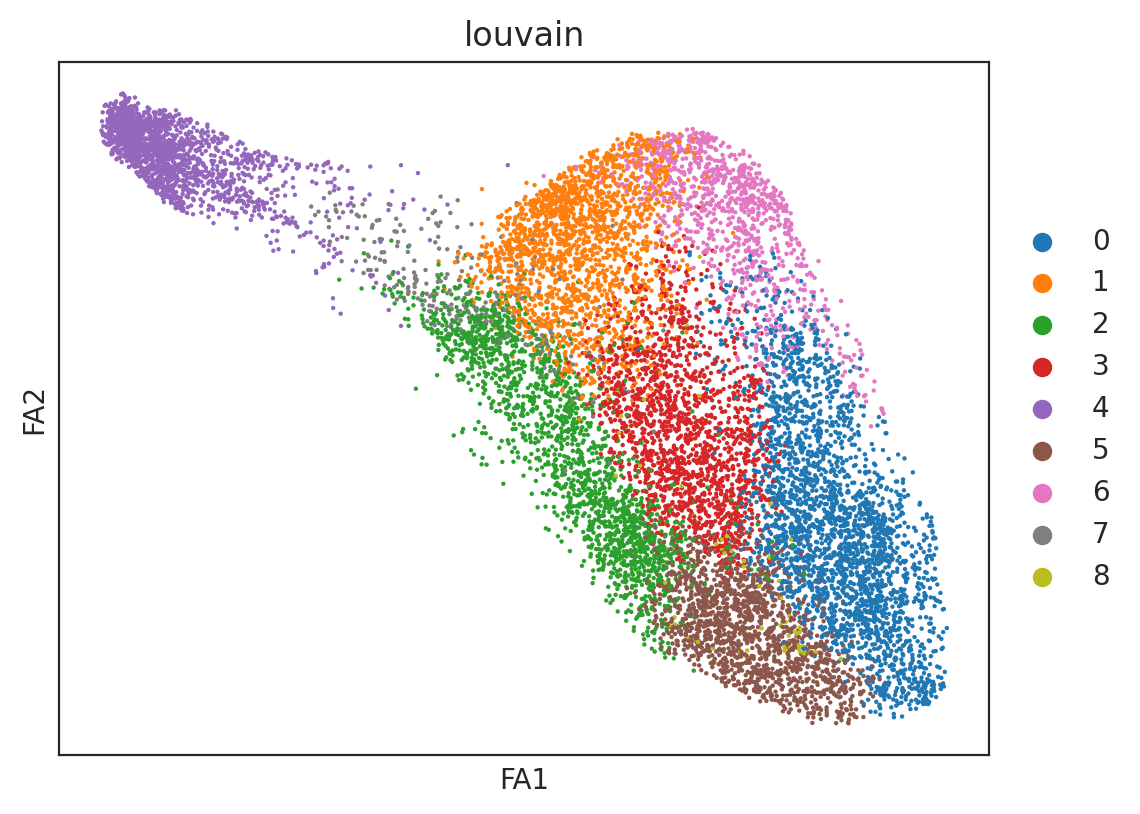

In [53]:
# GRN calculation
# Check clustering data
sc.pl.draw_graph(oracle.adata,color="louvain")

In [5]:
#5.1. Get GRNs
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="louvain_annot", alpha=10,
                         verbose_level=10,n_jobs=20)
# Save Links object.
links.to_hdf5(file_path=f"{res}links.celloracle.links")


In [8]:
# Set cluster name
# Save as csv
for cluster in links.cluster:
    links.links_dict[cluster].to_csv(f"{outputdata}{res}raw_GRN_for_{cluster}.csv")


In [9]:
# 6. Network preprocessing
# 6.1. Filter network edges

links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

PT-S1-A


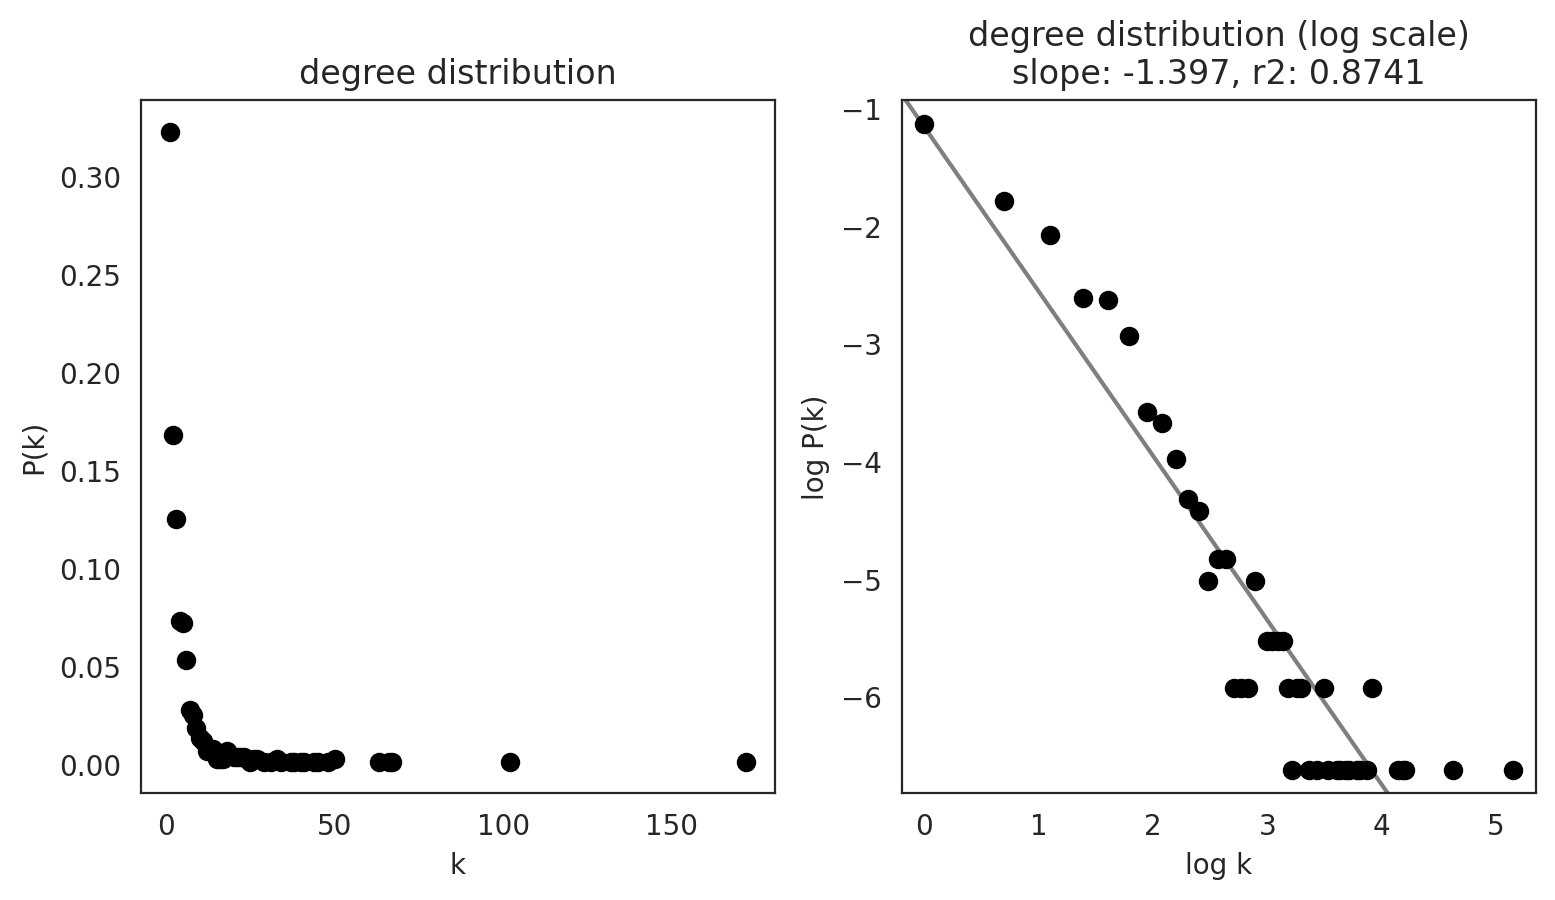

PT-S1-B


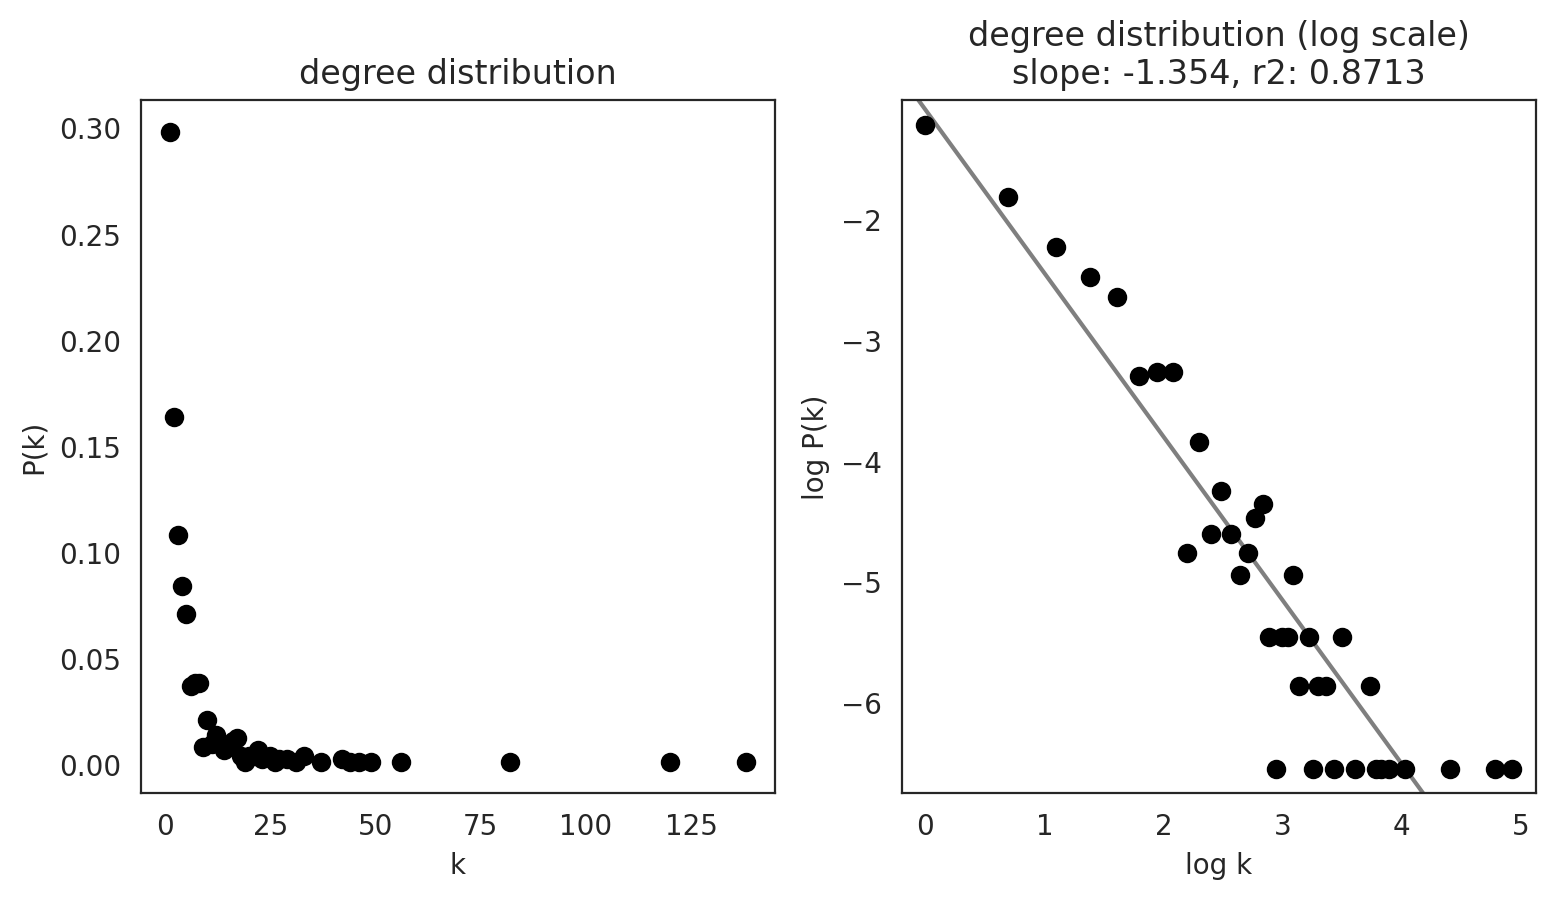

PT-S1-C


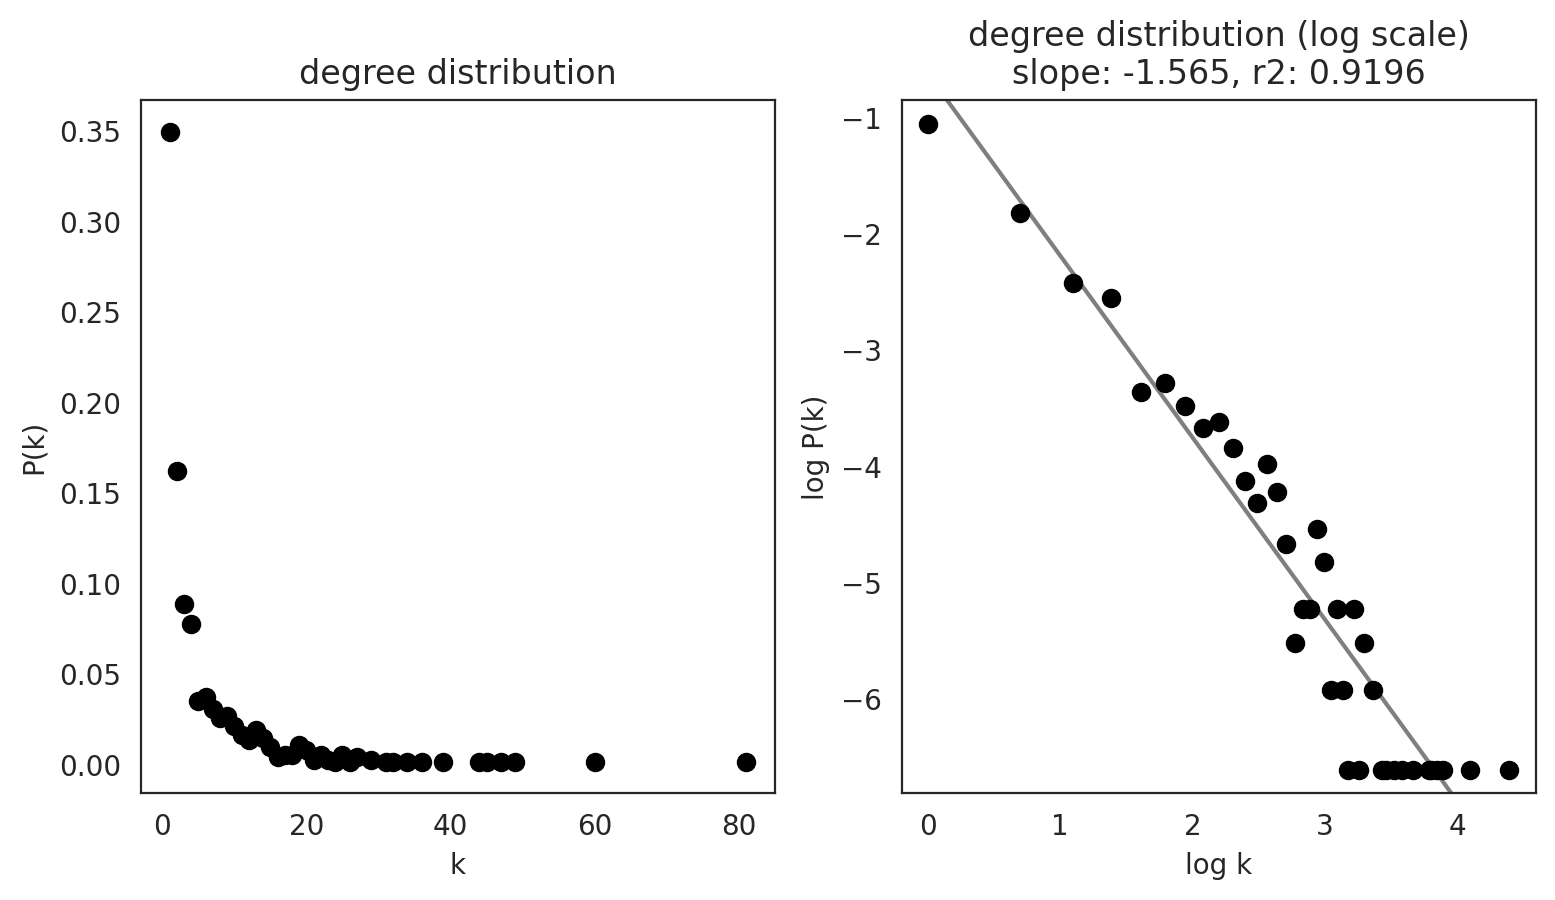

PT-S1-D


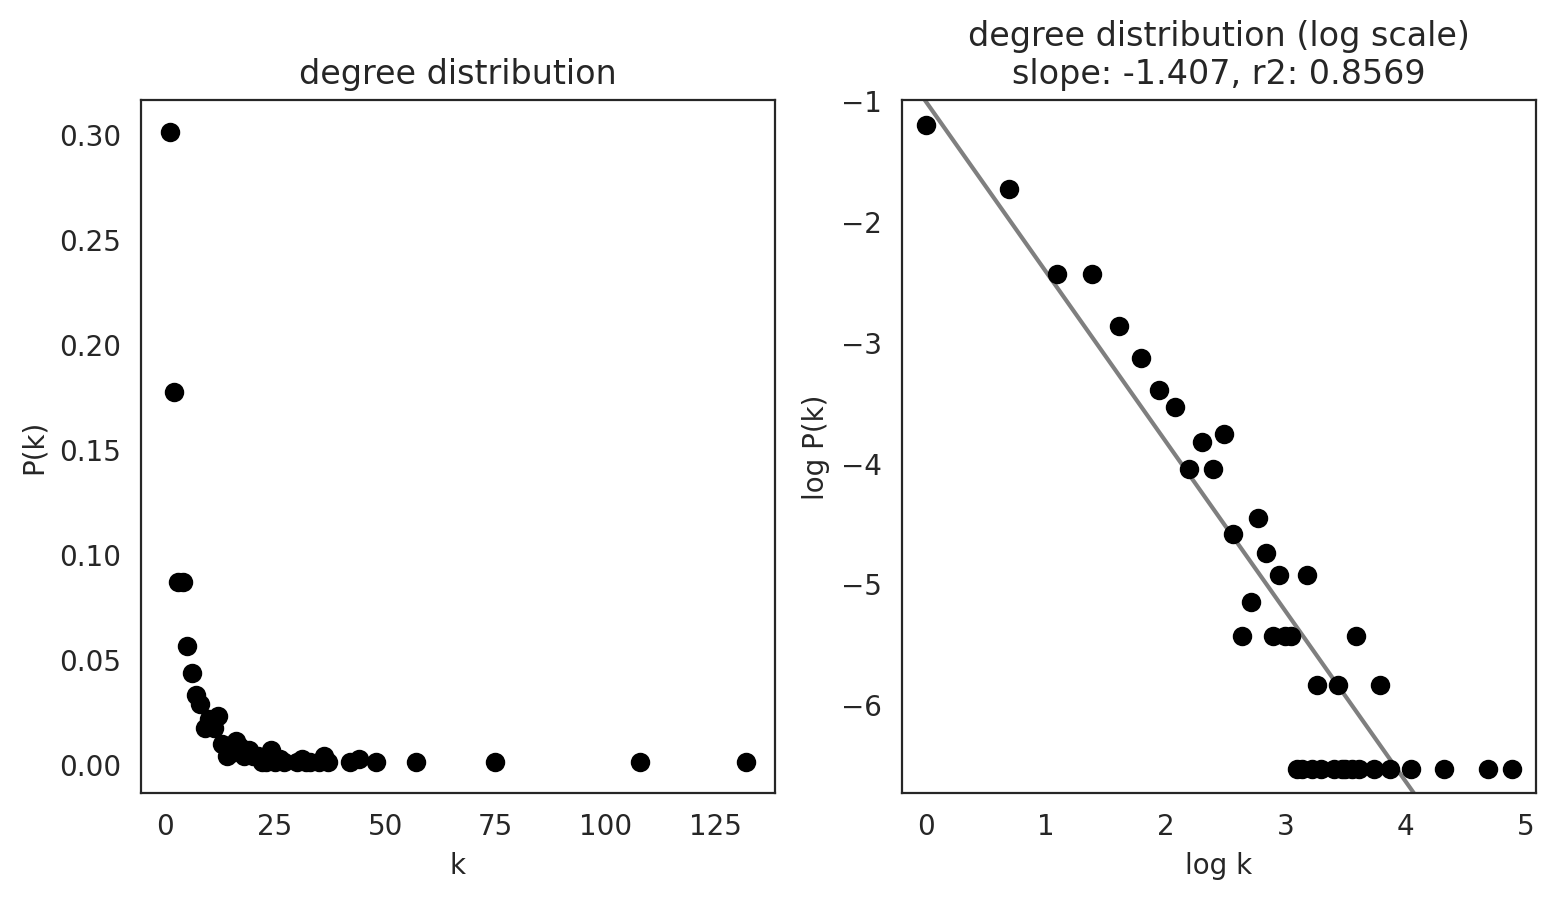

PT-S1-E


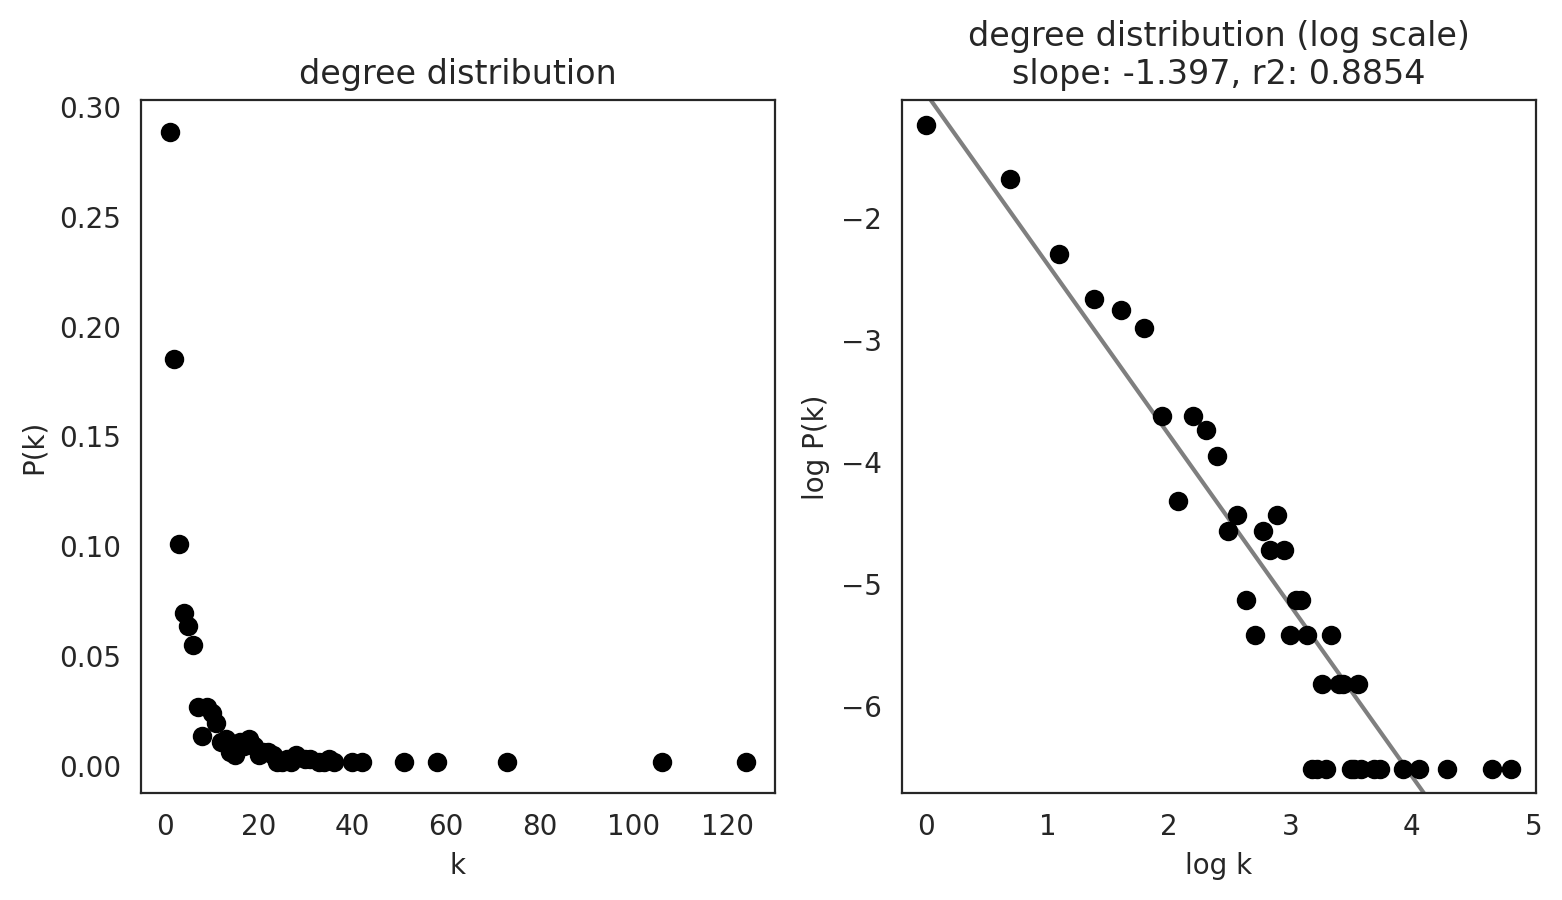

PT-S2-A


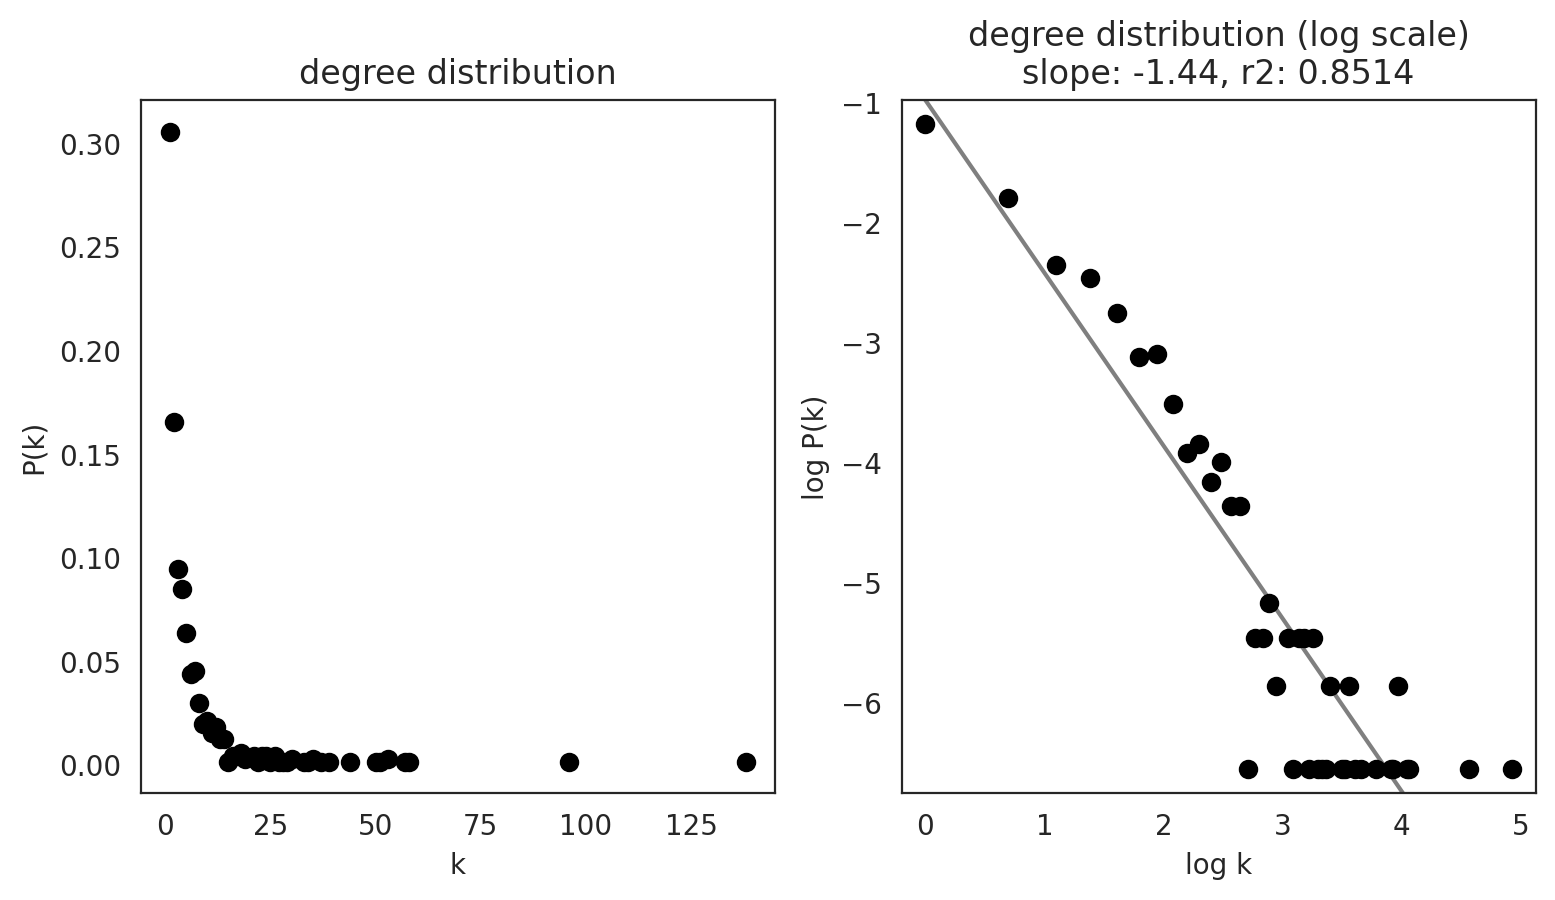

PT-S2-B


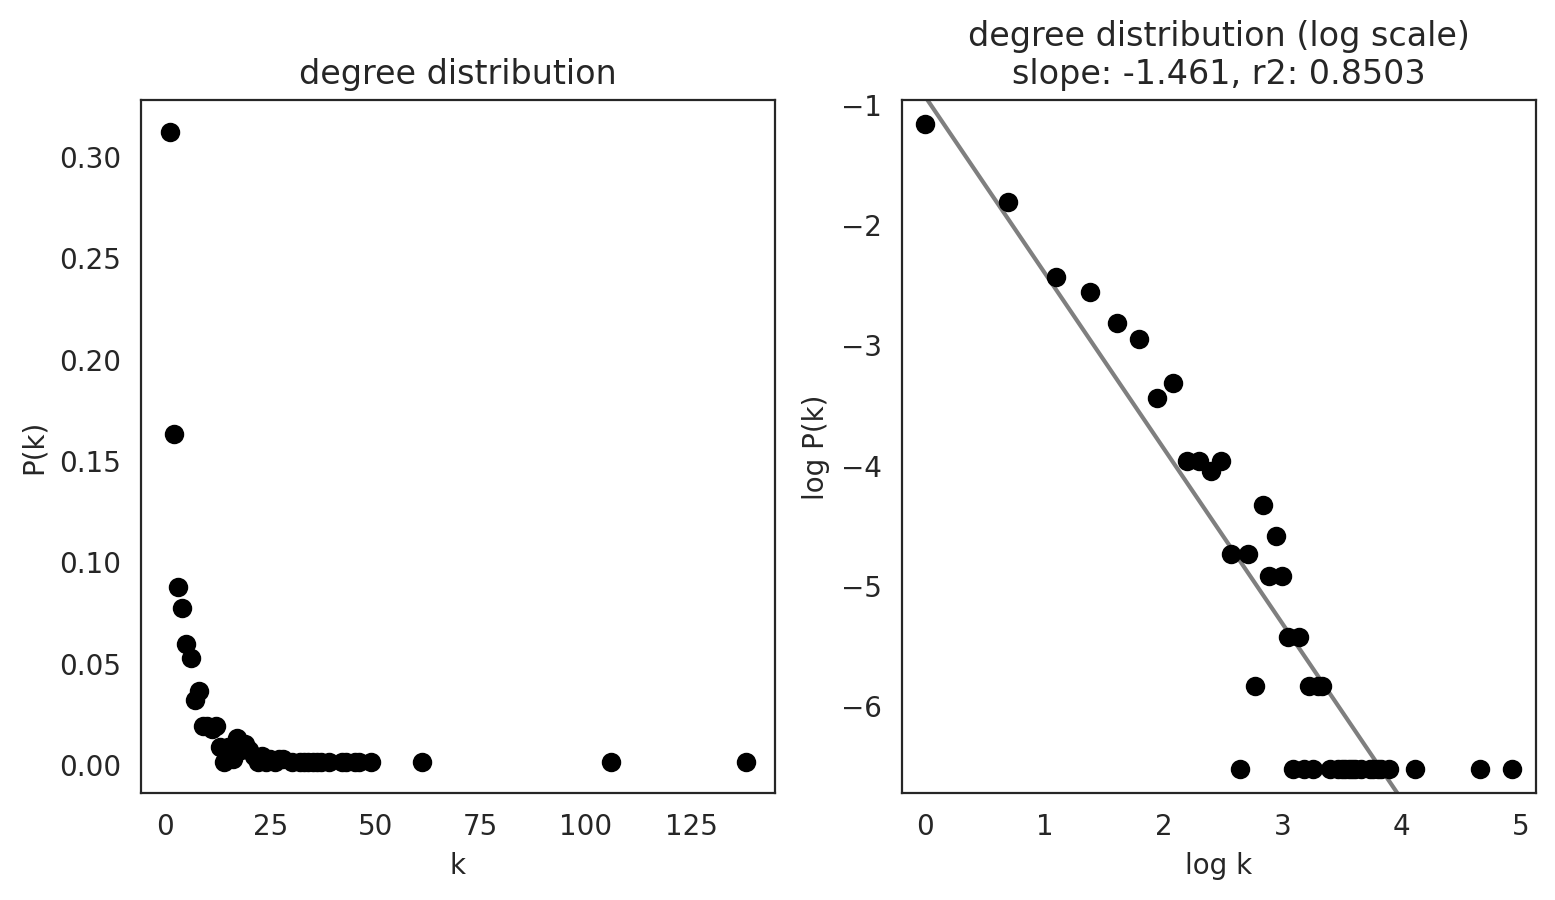

aPT-A


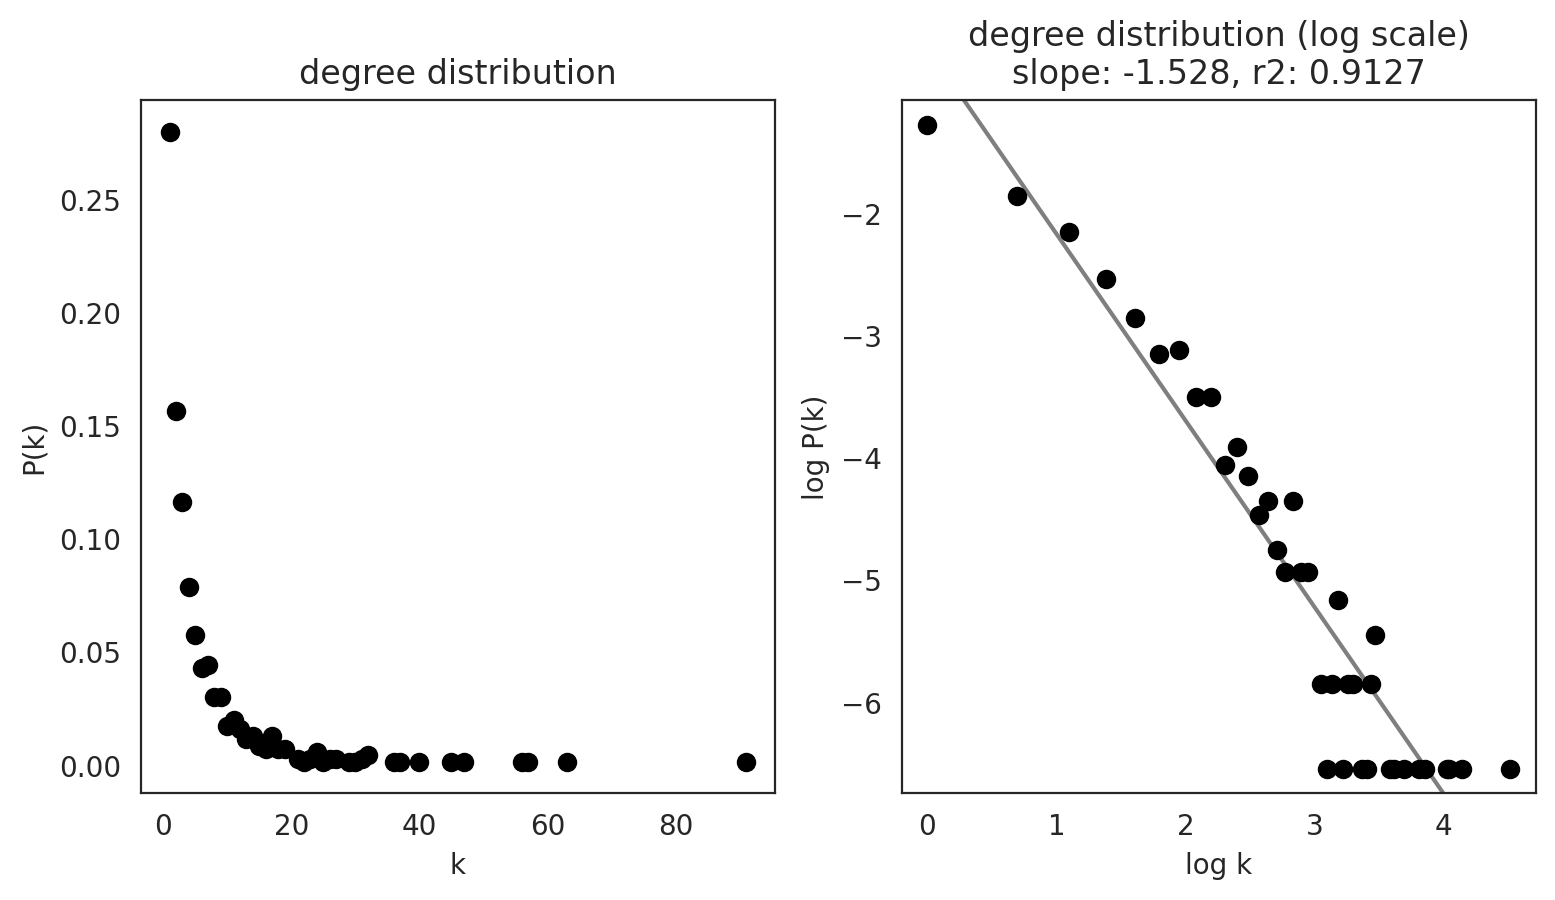

aPT-B


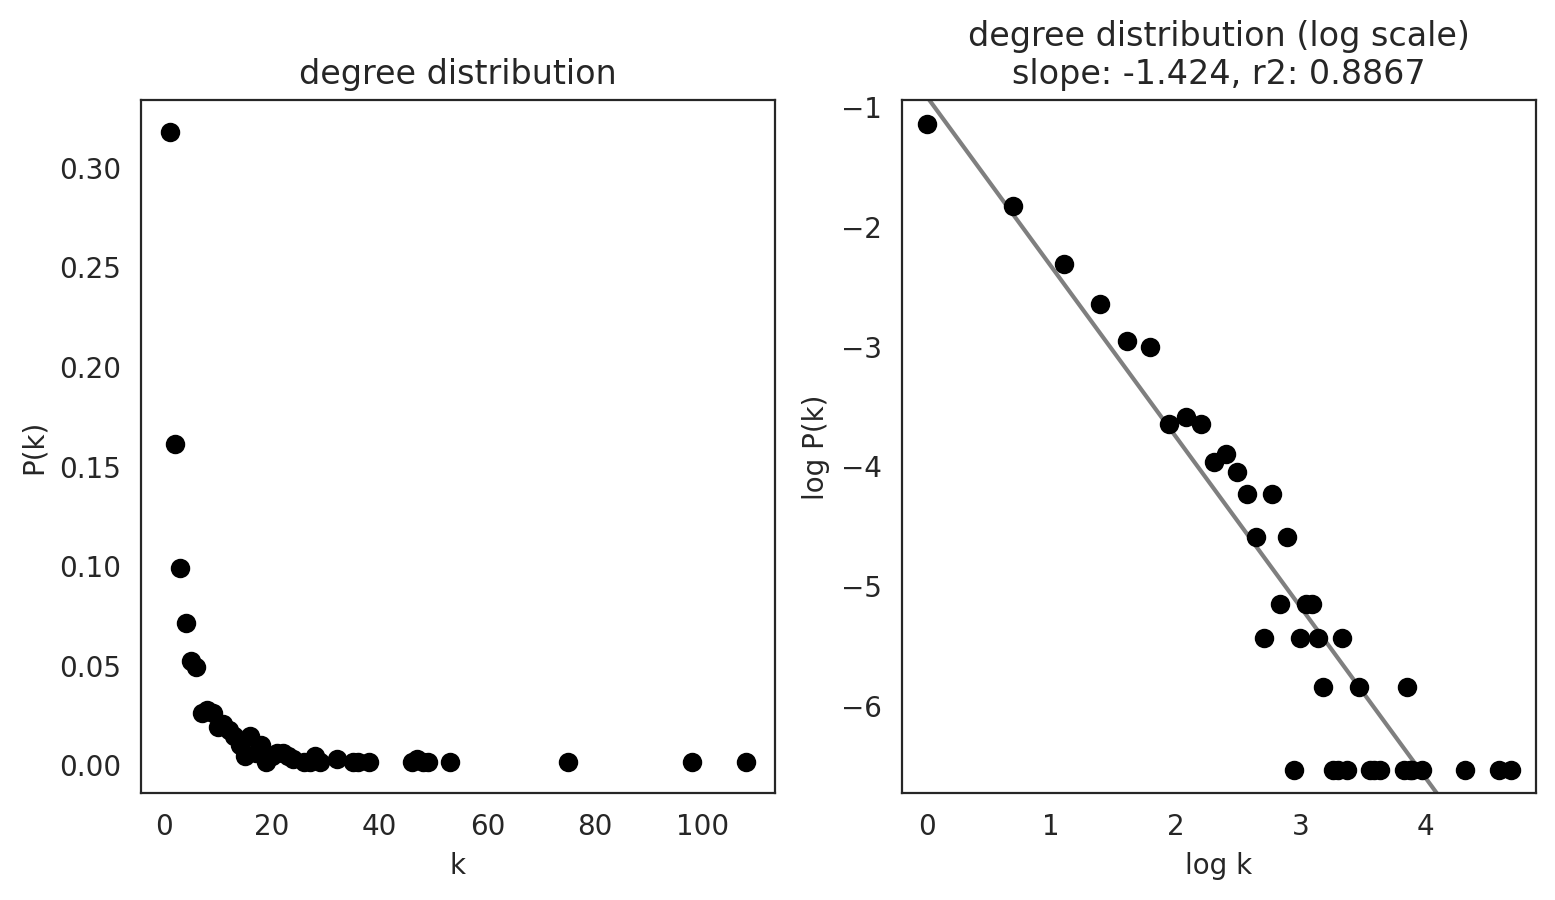

In [11]:
#6.2. Degree distribution
plt.rcParams["figure.figsize"] = [9, 4.5]

links.plot_degree_distributions(plot_model=True, 
                                              save=f"degree_distribution/",
                                              )

In [12]:
# Calculate network scores. 
links.get_network_score()

In [13]:
links.merged_score.head(100)

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
THRB             24               0.032043          0              0.000000   
XIST             14               0.018692         14              0.018692   
KLF7             63               0.084112          0              0.000000   
TCF7L2           45               0.060080          0              0.000000   
SIN3A             1               0.001335          0              0.000000   
...             ...                    ...        ...                   ...   
PLG               2               0.002670          2              0.002670   
RXRA             24               0.032043          0              0.000000   
NLGN1            11               0.014686         11              0.014686   
SPP1              4               0.005340          4              0.005340   
MAPKAP1           6               0.008011          6              0.008011   

         degree_out  degree_centrality_out  betweenness_centrality  \
THRB             24               0.032043                     0.0   
XIST              0               0.000000                     0.0   
KLF7             63               0.084112                     0.0   
TCF7L2           45               0.060080                     0.0   
SIN3A             1               0.001335                     0.0   
...             ...                    ...                     ...   
PLG               0               0.000000                     0.0   
RXRA             24               0.032043                     0.0   
NLGN1             0               0.000000                     0.0   
SPP1              0               0.000000                     0.0   
MAPKAP1           0               0.000000                     0.0   

         eigenvector_centrality  cluster  
THRB                   0.293906  PT-S1-A  
XIST                   0.350191  PT-S1-A  
KLF7                   0.294658  PT-S1-A  
TCF7L2                 0.353193  PT-S1-A  
SIN3A                  0.006117  PT-S1-A  
...                         ...      ...  
PLG                    0.103838  PT-S1-A  
RXRA                   0.099610  PT-S1-A  
NLGN1                  0.089849  PT-S1-A  
SPP1                   0.026590  PT-S1-A  
MAPKAP1                0.082160  PT-S1-A  

[100 rows x 9 columns]

In [14]:
# Save Links object.
links.to_hdf5(file_path=f"{outputdata}{res}links.celloracle.links")


[Step 7](https://morris-lab.github.io/CellOracle.documentation/notebooks/05_simulation/Gata1_KO_simulation_with_Paul_etal_2015_data.html)


In [ ]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
co.__version__
import os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm

In [7]:
#2. Make predictive models for simulation
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)
oracle.to_hdf5(f"{res}scMEGA_data_step3.celloracle.oracle")

  0%|          | 0/9 [00:00<?, ?it/s]